In [98]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import random

In [99]:
df = pd.read_csv('cleaned_hospital.csv')

grouped_df = df.groupby(['Year', 'APR DRG Code']).agg({
    'Discharges': 'sum',
    'Median Charge': 'median',
    'Median Cost': 'median'
}).reset_index()

# print(df['Year'].unique())
# print(sorted(df['Year'].unique()))

# grouped_df['Prev_Year_Discharges'] = grouped_df.groupby('APR DRG Code')['Discharges'].shift(1)
# grouped_df = grouped_df.dropna(subset=['Prev_Year_Discharges'])

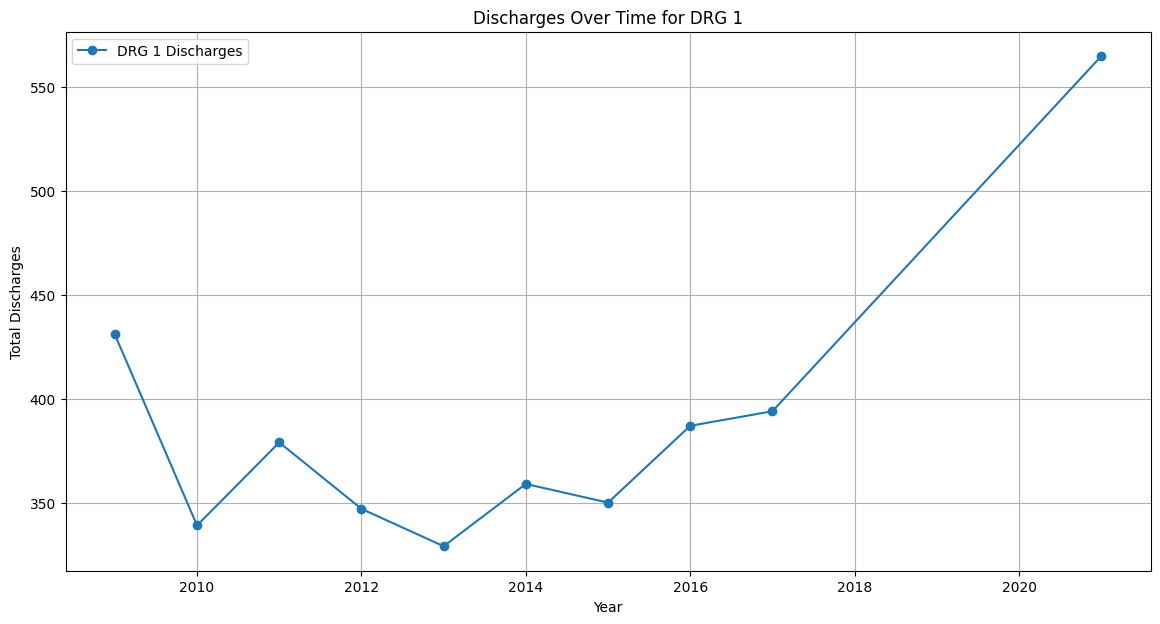

In [100]:
# Plotting charge to a DRG over time
selected_drg = 1
drg_data = df[df['APR DRG Code'] == selected_drg]

yearly_drg_data = drg_data.groupby('Year')['Discharges'].sum()

plt.figure(figsize=(14, 7))
plt.plot(yearly_drg_data.index, yearly_drg_data.values, marker='o', label=f'DRG {selected_drg} Discharges')
plt.title(f'Discharges Over Time for DRG {selected_drg}')
plt.xlabel('Year')
plt.ylabel('Total Discharges')
plt.legend()
plt.grid(True)
plt.show()

In [101]:
train_ratio = 0.8
actual_vs_predicted = {}

for drg in grouped_df['APR DRG Code'].unique():
    drg_data = grouped_df[grouped_df['APR DRG Code'] == drg].sort_values('Year')

    n_years = drg_data['Year'].nunique()

    if n_years >= 5:
        years = grouped_df['Year'].unique()
        years = list(years)

        random.shuffle(years)
        split_idx = int(len(years) * 0.8)

        train_years = years[:split_idx]
        test_years = years[split_idx:]

        train_data = drg_data[drg_data['Year'].isin(train_years)]
        test_data = drg_data[drg_data['Year'].isin(test_years)]

        if not test_data.empty:
            # feature_cols = ['Year', 'Median Charge', 'Median Cost', 'Prev_Year_Discharges']
            feature_cols = ['Year', 'Median Charge', 'Median Cost']
            X_train = train_data[feature_cols]
            y_train = train_data['Discharges']

            X_test = test_data[feature_cols]
            y_test_actual = test_data['Discharges']

            try:
                model = RandomForestRegressor(n_estimators=500, max_depth=6, random_state=42)
                model.fit(X_train, y_train)

                y_pred = model.predict(X_test)

                for true_val, pred_val in zip(y_test_actual, y_pred):
                    actual_vs_predicted[(drg, true_val)] = pred_val

                print(f"Training for DRG {drg}")

            except Exception as e:
                print(f"Failed for DRG {drg}: {e}")
    else:
        print(f"Not enough data for DRG {drg}")


Training for DRG 1
Training for DRG 2
Training for DRG 3
Training for DRG 4
Training for DRG 5
Training for DRG 6
Training for DRG 20
Training for DRG 21
Training for DRG 22
Training for DRG 23
Training for DRG 24
Training for DRG 26
Training for DRG 40
Training for DRG 41
Training for DRG 42
Training for DRG 43
Training for DRG 44
Training for DRG 45
Training for DRG 46
Training for DRG 47
Training for DRG 48
Training for DRG 49
Training for DRG 50
Training for DRG 51
Training for DRG 52
Training for DRG 53
Training for DRG 54
Training for DRG 55
Training for DRG 56
Training for DRG 57
Training for DRG 58
Training for DRG 70
Training for DRG 73
Training for DRG 80
Training for DRG 82
Training for DRG 89
Training for DRG 90
Training for DRG 91
Training for DRG 92
Training for DRG 93
Training for DRG 95
Training for DRG 97
Training for DRG 98
Training for DRG 110
Training for DRG 111
Training for DRG 113
Training for DRG 114
Training for DRG 115
Training for DRG 120
Training for DRG 121

<Figure size 1400x600 with 0 Axes>

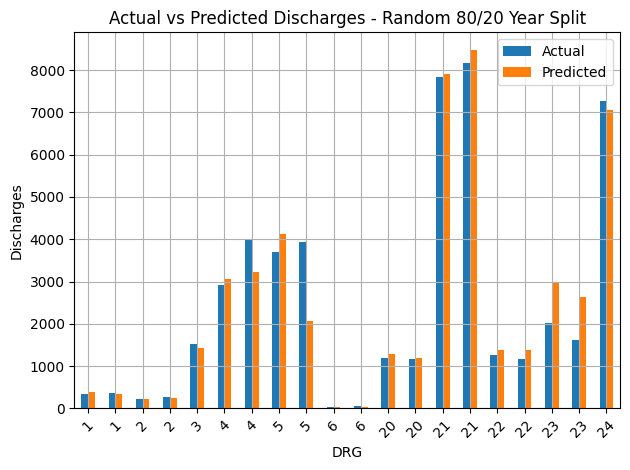

In [103]:
# Plotting

results_df = pd.DataFrame([
    {"DRG": drg, "Actual": actual, "Predicted": predicted}
    for (drg, actual), predicted in actual_vs_predicted.items()
])

results_df['Actual'] = pd.to_numeric(results_df['Actual'], errors='coerce')
results_df['Predicted'] = pd.to_numeric(results_df['Predicted'], errors='coerce')
results_df = results_df.dropna()

if not results_df.empty:
    plt.figure(figsize=(14, 6))
    subset = results_df.head(20)  # Take top 20 rows
    subset.plot(x='DRG', y=['Actual', 'Predicted'], kind='bar')
    plt.title('Actual vs Predicted Discharges - Random 80/20 Year Split')
    plt.xlabel('DRG')
    plt.ylabel('Discharges')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No results to plot.")


In [104]:
actual = results_df['Actual']
predicted = results_df['Predicted']

mse = mean_squared_error(actual, predicted)
rmse = mse ** 0.5
r2 = r2_score(actual, predicted)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

MSE: 10975455.89
RMSE: 3312.92
R² Score: 0.9638


In [84]:
results_df.head()

,DRG,Actual,Predicted
0,1,394.0,350.946
1,1,565.0,351.746
2,2,265.0,222.012
3,2,421.0,221.606
4,3,1624.0,1516.866
